In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [2]:
path = '/content/drive/MyDrive/phm'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Unbalance.csv', 'train_1st_Normal.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_2nd_Looseness.csv', 'train_2nd_Bearing.csv']


In [3]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-128
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

In [4]:
sub = pd.read_csv('/content/drive/MyDrive/phm_Result/sample_submission_classification (3).csv')
final = pd.read_csv('/content/drive/MyDrive/phm_Result/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final).batch(128).prefetch(1)

In [5]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

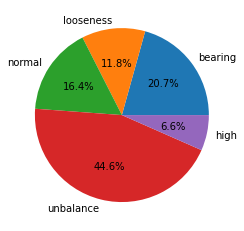

In [6]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [7]:
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 20)
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 50)
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 50)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0,window = 50 )
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0,window = 50)
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4,window = 50)
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4,window = 50 )

100%|██████████| 379456/379456 [00:21<00:00, 17558.53it/s]


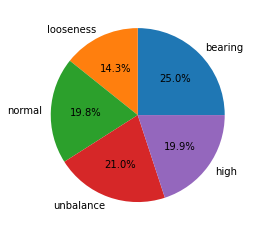

In [8]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [9]:
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(96).prefetch(1)

In [10]:
Dataset.__len__().numpy()

40880

In [11]:
Valid_Dataset = Dataset.take(3000) 
Train_Dataset = Dataset.skip(3000)

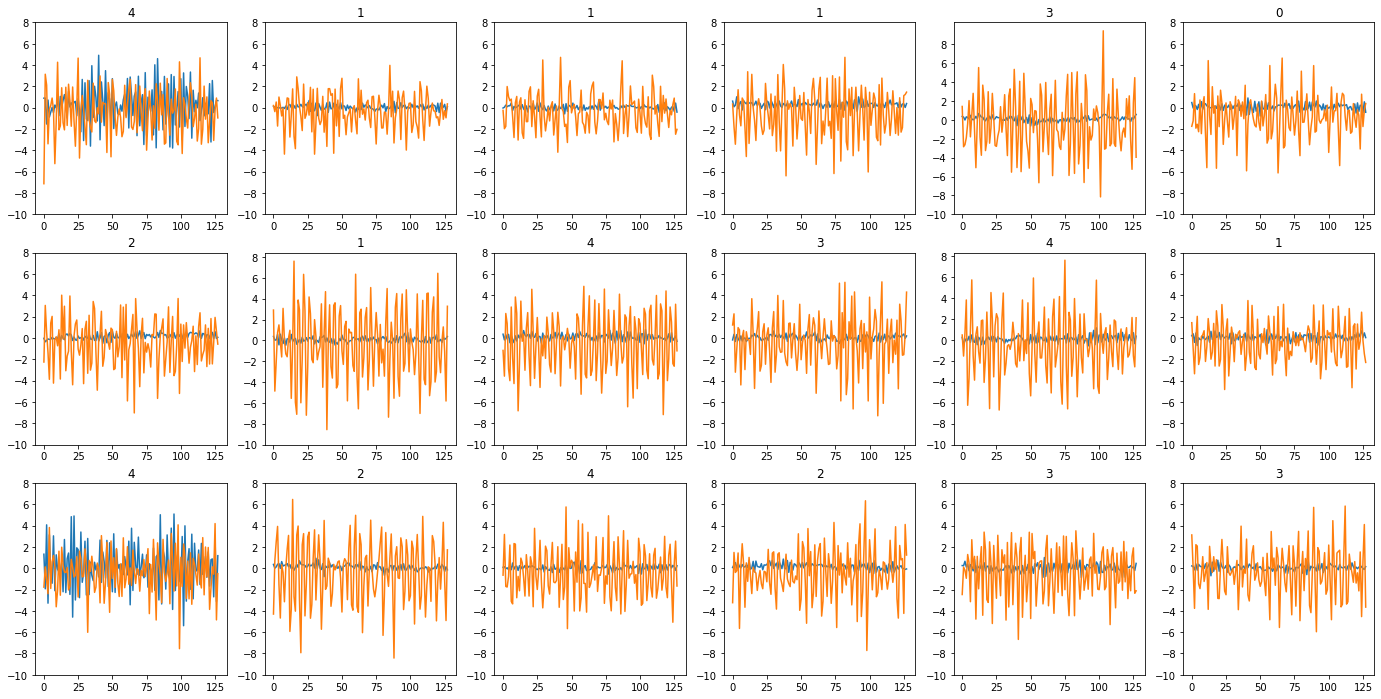

In [12]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

In [13]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[1][0]

IndexError: ignored

In [ ]:
Train_Dataset

In [14]:
import  pywt
from scipy import fftpack

In [15]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

NameError: ignored

In [ ]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

In [16]:
sample=list(Train_Dataset.unbatch().take(1000).as_numpy_iterator())

In [17]:
what=Train_Dataset.unbatch().take(1000).as_numpy_iterator()

In [18]:
a=Train_Dataset.unbatch().take(1000).as_numpy_iterator()

In [19]:
Train_Dataset

<SkipDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [20]:
CUSTOM_MODEL = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(128,2)),
        keras.layers.Dense(units = 5, activation = 'softmax'),
])

CUSTOM_MODEL.summary()

CUSTOM_MODEL.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?


CUSTOM_MODEL.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data =Valid_Dataset )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 5)            15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


InvalidArgumentError: ignored

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(128, 2)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data =Valid_Dataset)

Epoch 1/10
37880/37880 [==============================] - 95s 2ms/step - loss: 0.1483 - accuracy: 0.9430 - val_loss: 0.0179 - val_accuracy: 0.9943
Epoch 2/10
37880/37880 [==============================] - 95s 2ms/step - loss: 0.0395 - accuracy: 0.9873 - val_loss: 0.0108 - val_accuracy: 0.9964
Epoch 3/10
37880/37880 [==============================] - 94s 2ms/step - loss: 0.0302 - accuracy: 0.9905 - val_loss: 0.0091 - val_accuracy: 0.9971
Epoch 4/10
37880/37880 [==============================] - 94s 2ms/step - loss: 0.0257 - accuracy: 0.9921 - val_loss: 0.0072 - val_accuracy: 0.9978
Epoch 5/10
37880/37880 [==============================] - 94s 2ms/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.0065 - val_accuracy: 0.9981
Epoch 6/10
37880/37880 [==============================] - 93s 2ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0055 - val_accuracy: 0.9983
Epoch 7/10
37880/37880 [==============================] - 94s 2ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [23]:
test_Dataset

<PrefetchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1cc831f90>]],
      dtype=object)

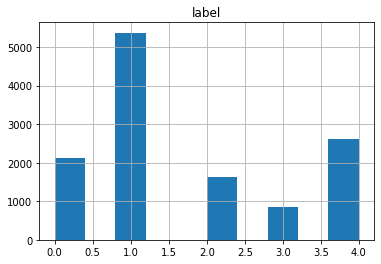

In [24]:
pred=model.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/phm_Result/result2.csv', index = False)
sub.hist()

In [ ]:
from keras import layers, models, Sequential, Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, AveragePooling2D, MaxPooling2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization, ZeroPadding2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

In [ ]:
model = Sequential()
inputShape = (128,2)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_class))
model.add(Activation("softmax"))



model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data =Valid_Dataset)

ValueError: ignored